# **7. Optimization Strategy - Improve Generalization & Optimization Methods**

## **1. Load the dataset**
---

We want to perform MNIST digit classification

- First download the data

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Load dataset
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=ToTensor(), download=True)
valid_dataset = datasets.FashionMNIST(root='data', train=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



- Visualize the dataset

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
sample_idx

30388

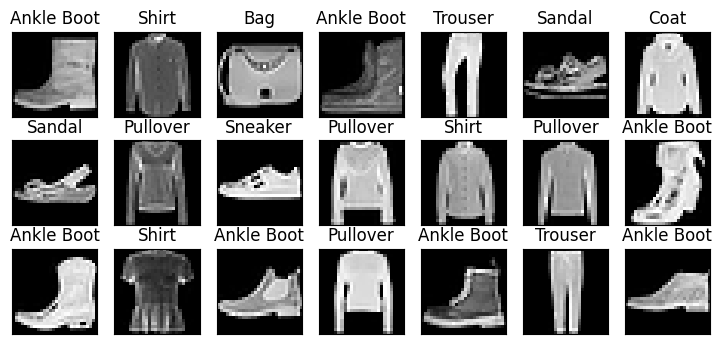

In [6]:
# Plot several sample
fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(9, 4))

torch.manual_seed(42)
for i in range(3):
    for j in range(7):
        # Get sample
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]

        # Plot
        axes[i,j].set_title(labels_map[label], size=12)
        axes[i,j].imshow(img.squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.show()

- Next we create a data loader

In [7]:
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

In [8]:
# Initialization for valid dataset min(1000, 10% train)
n_train = len(train_dataset)
valid_split_idx = min(1000, int(0.1*n_train))

n_train, valid_split_idx

(60000, 1000)

In [9]:
# Create a data sampler
torch.manual_seed(42)
train_sampler = SubsetRandomSampler(torch.arange(0, n_train-valid_split_idx))
valid_sampler = SubsetRandomSampler(torch.arange(n_train-valid_split_idx, n_train))

In [10]:
# Create the data loader
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          drop_last=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

- Great! We can check the dataset

In [11]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([0, 4, 5, 7, 0, 8, 3, 5, 1, 6])


## **2. Create Modular Function to Train and Evaluate**
---

- First, function to evaluate
- Because it's a multi-class classification task, we evaluate
  - the crossentropy loss
  - the accuracy

In [12]:
from torch.nn import functional as F

In [13]:
for i, (imgs, targets) in enumerate(train_dataset):
    print(imgs.shape)

    if i > 2:
        break

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [14]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [15]:
@torch.no_grad()    # Tell PyTorch to exclude the gradient calculations
def get_inference(model, type):
    """Get the model accuracy"""
    # Get the data loader
    data_loader = {
        'train': train_loader,
        'valid': valid_loader,
        'test': test_loader
    }[type]

    correct_pred, num_samples, loss = 0, 0, 0.

    model.eval()
    for i, (imgs, targets) in enumerate(data_loader):
        # Predict
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(probs, 1)

        # Calculate acc & loss
        correct_pred += (preds == targets).sum()
        num_samples += targets.size(0)
        loss += targets.size(0) * F.cross_entropy(logits, targets)

    # Find the mean loss & acc
    loss = loss / num_samples
    acc = 100 * correct_pred.float()/num_samples

    return acc, loss


- Next, we create the train function

In [16]:
import time

In [17]:
def train(model, max_epoch, train_loader, optimizer):
    """Train the model"""
    # Initialize
    train_acc_list = []
    valid_acc_list = []
    losses = []

    # Start iteration
    start_time = time.time()
    for epoch in range(max_epoch):
        # Training -- iterate over batch
        model.train()
        for batch_idx, (imgs, targets) in enumerate(train_loader):
            # Forward pass
            logits = model(imgs)
            loss = F.cross_entropy(logits, targets)

            # Backpropagation
            model.zero_grad(set_to_none=True)
            loss.backward()

            # Update the model parameter
            optimizer.step()

            # Log the minibatch (inner iteration)
            losses.append(loss.item())
            if not batch_idx % int(len(train_loader)/2.):
                print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                      f'| Batch: {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        # Inference
        model.eval()
        with torch.no_grad():
            train_acc, _ = get_inference(model, 'train')
            valid_acc, _ = get_inference(model, 'valid')

            print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                  f'| Train: {train_acc:.2f}% '
                  f'| Valid: {valid_acc:.2f}%')
            print('')

            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

    # Finalize
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    return losses, train_acc_list, valid_acc_list


## **Task 1: Create Model MLP & Train it**
---

In [18]:
import torch
import torch.nn as nn
from dataclasses import dataclass

- Create a config class

In [19]:
@dataclass
class ModelConfig:
    # Config model
    n_in: int = 784             # input size
    n_hidden: int = 50          # hidden layer size
    n_out: int = 10             # output size
    drop_proba: float = 0.5     # dropout probability
    lamda: float = 0.1          # regularizer strength

    # Config train
    lr: float = 0.1             # learning rates
    max_epochs: int = 50        # maximum epochs

In [20]:
CONFIG = ModelConfig()
CONFIG

ModelConfig(n_in=784, n_hidden=50, n_out=10, drop_proba=0.5, lamda=0.1, lr=0.1, max_epochs=50)

- Now, lets initialize the model

In [21]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Create the MLP
        torch.manual_seed(42)
        self.mlp = nn.Sequential(
            # Flatten
            nn.Flatten(),

            # 1st hidden layer
            nn.Linear(config.n_in, 2*config.n_hidden),
            nn.ReLU(),

            # Output layer
            nn.Linear(2*config.n_hidden, config.n_out)
        )

    def forward(self, X):
        logits = self.mlp(X)
        return logits


In [22]:
# Initialize models
model_mlp = MLP(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp.parameters()))

Total parameters : 79510


- Then, we start training

In [23]:
# Define optimizer
optimizer_1 = torch.optim.SGD(params = model_mlp.parameters(),
                              lr = CONFIG.lr)

In [24]:
losses_mlp, train_acc_mlp, valid_acc_mlp = train(model=model_mlp,
                                                 max_epoch=CONFIG.max_epochs,
                                                 train_loader=train_loader,
                                                 optimizer=optimizer_1)

Epoch: 001/050 | Batch: 0000/0921 | Loss: 2.3259
Epoch: 001/050 | Batch: 0460/0921 | Loss: 0.3795
Epoch: 001/050 | Batch: 0920/0921 | Loss: 0.3748
Epoch: 001/050 | Train: 83.93% | Valid: 83.80%

Epoch: 002/050 | Batch: 0000/0921 | Loss: 0.4380
Epoch: 002/050 | Batch: 0460/0921 | Loss: 0.5804
Epoch: 002/050 | Batch: 0920/0921 | Loss: 0.3960
Epoch: 002/050 | Train: 86.39% | Valid: 86.10%

Epoch: 003/050 | Batch: 0000/0921 | Loss: 0.6009
Epoch: 003/050 | Batch: 0460/0921 | Loss: 0.3308
Epoch: 003/050 | Batch: 0920/0921 | Loss: 0.2053
Epoch: 003/050 | Train: 86.60% | Valid: 86.50%

Epoch: 004/050 | Batch: 0000/0921 | Loss: 0.4424
Epoch: 004/050 | Batch: 0460/0921 | Loss: 0.3003
Epoch: 004/050 | Batch: 0920/0921 | Loss: 0.2483
Epoch: 004/050 | Train: 87.08% | Valid: 86.20%

Epoch: 005/050 | Batch: 0000/0921 | Loss: 0.5608
Epoch: 005/050 | Batch: 0460/0921 | Loss: 0.3636
Epoch: 005/050 | Batch: 0920/0921 | Loss: 0.4332
Epoch: 005/050 | Train: 87.30% | Valid: 86.60%

Epoch: 006/050 | Batch: 0

- Plot the loss & accuracy

In [25]:
import numpy as np

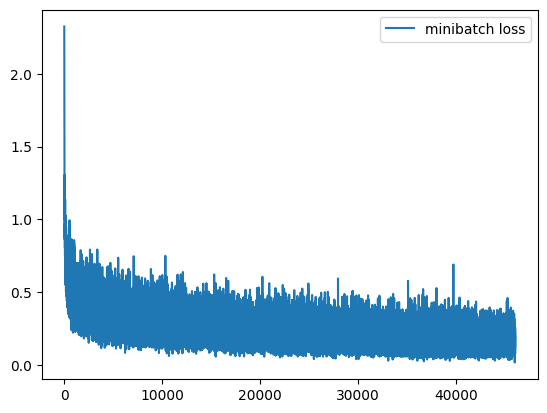

In [26]:
plt.plot(np.arange(len(losses_mlp)), losses_mlp, c='tab:blue', label='minibatch loss')
plt.legend()
plt.show()

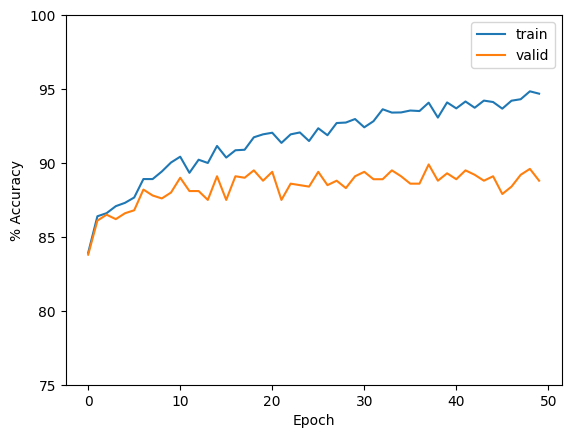

In [27]:
plt.plot(np.arange(len(train_acc_mlp)), train_acc_mlp, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp)), valid_acc_mlp, c='tab:orange', label='valid')
plt.ylabel('% Accuracy'); plt.xlabel('Epoch')
plt.ylim(75, 100)
plt.legend()
plt.show()

- Validate on train & valid data

In [28]:
# Calculate
train_acc_mlp, train_loss_mlp = get_inference(model_mlp, 'train')
valid_acc_mlp, valid_loss_mlp = get_inference(model_mlp, 'valid')

In [29]:
import pandas as pd

In [30]:
# Summarize in dataframe
summary_df = pd.DataFrame(
    np.array([[train_acc_mlp, valid_acc_mlp, train_loss_mlp, valid_loss_mlp]]),
    index = ['MLP'],
    columns = ['Train Acc', 'Valid Acc', 'Train Loss', 'Valid Loss']
)

summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,94.689873,88.800003,0.147846,0.327279


- Finally, we predict the model samples

In [31]:
# Get the samples data
X_samples, y_samples = next(iter(valid_loader))

In [32]:
# Get prediction
model_mlp.eval()
with torch.no_grad():
    logits_sample = model_mlp(X_samples)
    probs_sample = F.softmax(logits_sample, dim=1)
    y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([6, 5, 3, 6, 7, 8, 0, 4, 9, 4, 9, 7, 3, 1, 3, 0, 2, 9, 1, 7, 4, 7, 5, 0,
        0, 7, 0, 8, 1, 2, 6, 6, 1, 2, 1, 6, 7, 7, 4, 9, 8, 7, 7, 1, 0, 0, 5, 3,
        6, 6, 5, 1, 5, 0, 6, 4, 0, 8, 8, 8, 1, 9, 2, 5])

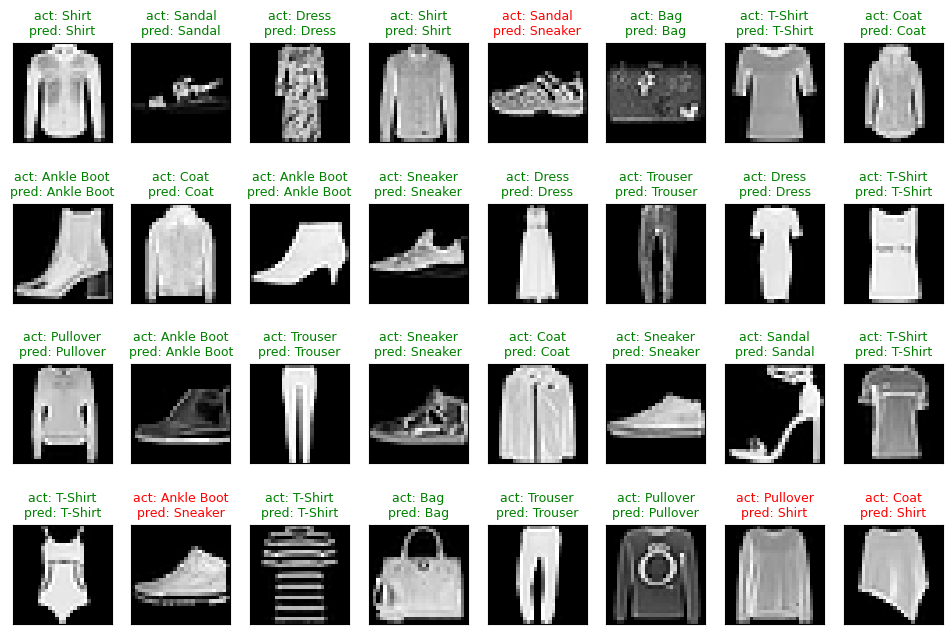

In [33]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(12, 8))
index = 0
for i in range(4):
    for j in range(8):
        act_label = labels_map[y_samples[index].item()]
        pred_label = labels_map[y_samples_pred[index].item()]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 2: Create a Deeper Model MLP & Train it**
---

- Create the model class

In [34]:
class MLPDeeper(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Create the MLP
        torch.manual_seed(42)
        self.mlp = nn.Sequential(
            # Input layer
            nn.Flatten(),

            # 1st hidden layer
            nn.Linear(config.n_in, config.n_hidden),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(config.n_hidden, config.n_hidden),
            nn.ReLU(),

            # Output layer
            nn.Linear(config.n_hidden, config.n_out)
        )

    def forward(self, X):
        logits = self.mlp(X)
        return logits


In [35]:
# Initialize models
model_mlp_deeper = MLPDeeper(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp_deeper.parameters()))

Total parameters : 42310


- Then, we start training

In [36]:
# Define optimizer
optimizer_2 = torch.optim.SGD(params = model_mlp_deeper.parameters(),
                              lr = CONFIG.lr)

In [37]:
losses_mlp_deeper, train_acc_mlp_deeper, valid_acc_mlp_deeper = train(model=model_mlp_deeper,
                                                                      max_epoch=CONFIG.max_epochs,
                                                                      train_loader=train_loader,
                                                                      optimizer=optimizer_2)

Epoch: 001/050 | Batch: 0000/0921 | Loss: 2.3315
Epoch: 001/050 | Batch: 0460/0921 | Loss: 0.8525
Epoch: 001/050 | Batch: 0920/0921 | Loss: 0.5912
Epoch: 001/050 | Train: 82.75% | Valid: 82.80%

Epoch: 002/050 | Batch: 0000/0921 | Loss: 0.6852
Epoch: 002/050 | Batch: 0460/0921 | Loss: 0.5381
Epoch: 002/050 | Batch: 0920/0921 | Loss: 0.4309
Epoch: 002/050 | Train: 84.93% | Valid: 84.70%

Epoch: 003/050 | Batch: 0000/0921 | Loss: 0.1876
Epoch: 003/050 | Batch: 0460/0921 | Loss: 0.3966
Epoch: 003/050 | Batch: 0920/0921 | Loss: 0.4651
Epoch: 003/050 | Train: 84.78% | Valid: 85.30%

Epoch: 004/050 | Batch: 0000/0921 | Loss: 0.3855
Epoch: 004/050 | Batch: 0460/0921 | Loss: 0.3483
Epoch: 004/050 | Batch: 0920/0921 | Loss: 0.3335
Epoch: 004/050 | Train: 87.44% | Valid: 87.30%

Epoch: 005/050 | Batch: 0000/0921 | Loss: 0.4092
Epoch: 005/050 | Batch: 0460/0921 | Loss: 0.4021
Epoch: 005/050 | Batch: 0920/0921 | Loss: 0.4310
Epoch: 005/050 | Train: 86.92% | Valid: 86.10%

Epoch: 006/050 | Batch: 0

- Plot the loss & accuracy

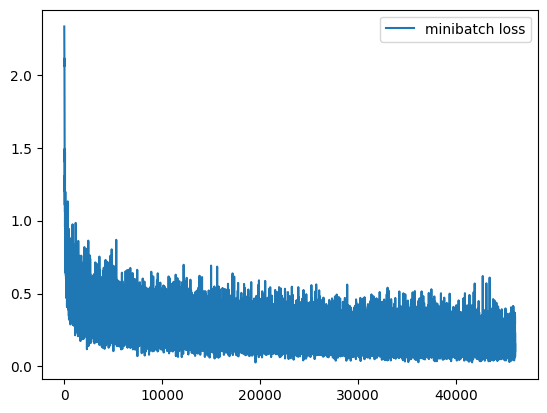

In [38]:
plt.plot(np.arange(len(losses_mlp_deeper)), losses_mlp_deeper, c='tab:blue', label='minibatch loss')
plt.legend()
plt.show()

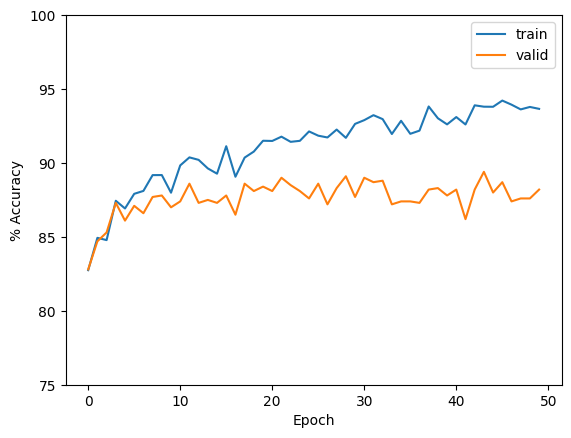

In [39]:
plt.plot(np.arange(len(train_acc_mlp_deeper)), train_acc_mlp_deeper, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp_deeper)), valid_acc_mlp_deeper, c='tab:orange', label='valid')
plt.ylabel('% Accuracy'); plt.xlabel('Epoch')
plt.ylim(75, 100)
plt.legend()
plt.show()

- Validate on train & valid data

In [40]:
# Calculate
train_acc_mlp_deeper, train_loss_mlp_deeper = get_inference(model_mlp_deeper, 'train')
valid_acc_mlp_deeper, valid_loss_mlp_deeper = get_inference(model_mlp_deeper, 'valid')

In [41]:
# Summarize in dataframe
summary_df.loc['MLP Deeper'] = np.array([train_acc_mlp_deeper,
                                         valid_acc_mlp_deeper,
                                         train_loss_mlp_deeper,
                                         valid_loss_mlp_deeper])
summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,94.689873,88.800003,0.147846,0.327279
MLP Deeper,93.661781,88.199997,0.163049,0.387818


- Finally, we predict the model samples

In [42]:
# Get prediction
model_mlp.eval()
with torch.no_grad():
    logits_sample = model_mlp_deeper(X_samples)
    probs_sample = F.softmax(logits_sample, dim=1)
    y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([6, 5, 3, 6, 7, 8, 0, 4, 9, 4, 9, 7, 3, 1, 3, 6, 2, 9, 1, 7, 1, 7, 5, 0,
        0, 7, 0, 8, 1, 2, 6, 8, 1, 2, 1, 4, 7, 7, 4, 9, 8, 7, 7, 1, 0, 0, 5, 3,
        2, 4, 5, 1, 5, 0, 6, 4, 0, 8, 8, 8, 1, 9, 2, 5])

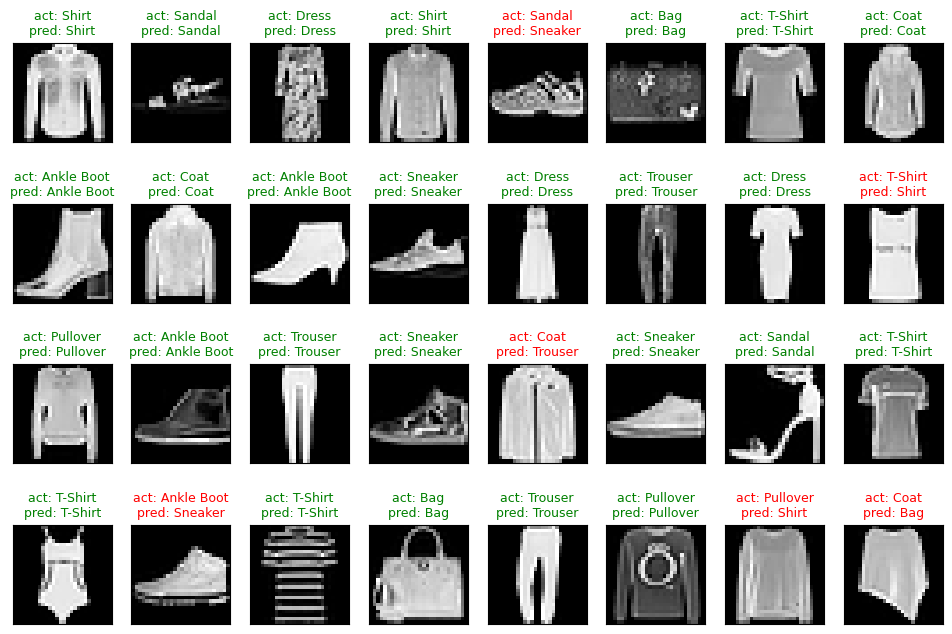

In [43]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(12, 8))
index = 0
for i in range(4):
    for j in range(8):
        act_label = labels_map[y_samples[index].item()]
        pred_label = labels_map[y_samples_pred[index].item()]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 3: Create a Model MLP with Dropout**
---

- Create the model class

In [44]:
class MLPDropout(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Create the MLP
        torch.manual_seed(42)
        self.mlp = nn.Sequential(
            # input layer
            nn.Flatten(),

            # 1st hidden layer
            nn.Linear(config.n_in, config.n_hidden),
            nn.ReLU(),
            nn.Dropout(config.drop_proba),

            # 2nd hidden layer
            nn.Linear(config.n_hidden, config.n_hidden),
            nn.ReLU(),
            nn.Dropout(config.drop_proba),

            # Output layer
            nn.Linear(config.n_hidden, config.n_out)
        )

    def forward(self, X):
        logits = self.mlp(X)
        return logits


In [45]:
# Initialize models
model_mlp_dropout = MLPDropout(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp_dropout.parameters()))

Total parameters : 42310


- Then, we start training

In [46]:
# Define optimizer
optimizer_3 = torch.optim.SGD(params = model_mlp_dropout.parameters(),
                              lr = CONFIG.lr)

In [47]:
losses_mlp_dropout, train_acc_mlp_dropout, valid_acc_mlp_dropout = train(model=model_mlp_dropout,
                                                                         max_epoch=CONFIG.max_epochs,
                                                                         train_loader=train_loader,
                                                                         optimizer=optimizer_3)

Epoch: 001/050 | Batch: 0000/0921 | Loss: 2.3272
Epoch: 001/050 | Batch: 0460/0921 | Loss: 1.0992
Epoch: 001/050 | Batch: 0920/0921 | Loss: 1.0892
Epoch: 001/050 | Train: 77.29% | Valid: 78.00%

Epoch: 002/050 | Batch: 0000/0921 | Loss: 0.7912
Epoch: 002/050 | Batch: 0460/0921 | Loss: 0.5702
Epoch: 002/050 | Batch: 0920/0921 | Loss: 0.6488
Epoch: 002/050 | Train: 80.61% | Valid: 80.40%

Epoch: 003/050 | Batch: 0000/0921 | Loss: 0.8764
Epoch: 003/050 | Batch: 0460/0921 | Loss: 0.6746
Epoch: 003/050 | Batch: 0920/0921 | Loss: 0.5372


Epoch: 003/050 | Train: 83.00% | Valid: 82.50%

Epoch: 004/050 | Batch: 0000/0921 | Loss: 0.5882
Epoch: 004/050 | Batch: 0460/0921 | Loss: 0.4251
Epoch: 004/050 | Batch: 0920/0921 | Loss: 0.5491
Epoch: 004/050 | Train: 84.22% | Valid: 83.10%

Epoch: 005/050 | Batch: 0000/0921 | Loss: 0.6183
Epoch: 005/050 | Batch: 0460/0921 | Loss: 0.5098
Epoch: 005/050 | Batch: 0920/0921 | Loss: 0.4941
Epoch: 005/050 | Train: 84.50% | Valid: 84.50%

Epoch: 006/050 | Batch: 0000/0921 | Loss: 0.5910
Epoch: 006/050 | Batch: 0460/0921 | Loss: 0.6066
Epoch: 006/050 | Batch: 0920/0921 | Loss: 0.4304
Epoch: 006/050 | Train: 85.27% | Valid: 84.90%

Epoch: 007/050 | Batch: 0000/0921 | Loss: 0.3481
Epoch: 007/050 | Batch: 0460/0921 | Loss: 0.5194
Epoch: 007/050 | Batch: 0920/0921 | Loss: 0.4364
Epoch: 007/050 | Train: 85.09% | Valid: 85.10%

Epoch: 008/050 | Batch: 0000/0921 | Loss: 0.9563
Epoch: 008/050 | Batch: 0460/0921 | Loss: 0.4238
Epoch: 008/050 | Batch: 0920/0921 | Loss: 0.4939
Epoch: 008/050 | Train: 8

- Plot the loss & accuracy

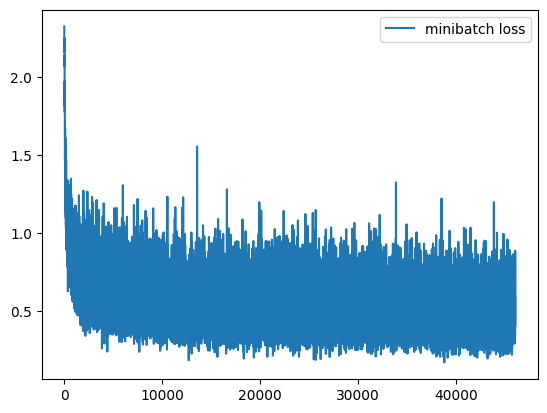

In [48]:
plt.plot(np.arange(len(losses_mlp_dropout)), losses_mlp_dropout, c='tab:blue', label='minibatch loss')
plt.legend()
plt.show()

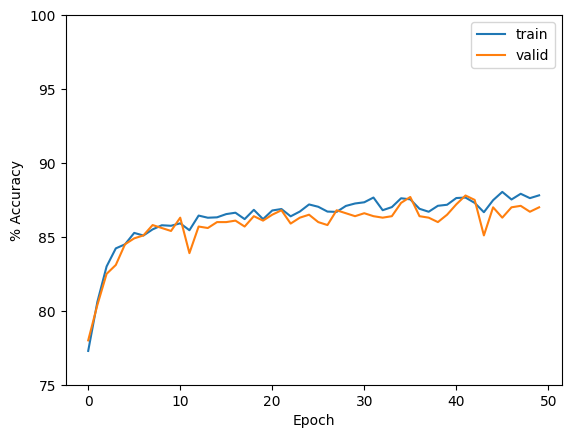

In [49]:
plt.plot(np.arange(len(train_acc_mlp_dropout)), train_acc_mlp_dropout, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp_dropout)), valid_acc_mlp_dropout, c='tab:orange', label='valid')
plt.ylabel('% Accuracy'); plt.xlabel('Epoch')
plt.ylim(75, 100)
plt.legend()
plt.show()

- Validate on train & valid data

In [50]:
# Calculate
train_acc_mlp_dropout, train_loss_mlp_dropout = get_inference(model_mlp_dropout, 'train')
valid_acc_mlp_dropout, valid_loss_mlp_dropout = get_inference(model_mlp_dropout, 'valid')

In [51]:
# Summarize in dataframe
summary_df.loc['MLP dropout'] = np.array([train_acc_mlp_dropout,
                                         valid_acc_mlp_dropout,
                                         train_loss_mlp_dropout,
                                         valid_loss_mlp_dropout])
summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,94.689873,88.800003,0.147846,0.327279
MLP Deeper,93.661781,88.199997,0.163049,0.387818
MLP dropout,87.813858,87.000000,0.331931,0.377901


- Finally, we predict the model samples

In [52]:
# Get prediction
model_mlp.eval()
with torch.no_grad():
    logits_sample = model_mlp_dropout(X_samples)
    probs_sample = F.softmax(logits_sample, dim=1)
    y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([2, 5, 3, 6, 7, 8, 0, 4, 9, 4, 9, 7, 3, 1, 3, 0, 2, 5, 1, 7, 2, 7, 5, 0,
        0, 7, 0, 8, 1, 2, 2, 2, 1, 2, 1, 4, 7, 7, 4, 9, 8, 7, 7, 1, 0, 0, 5, 4,
        6, 6, 5, 1, 5, 0, 6, 4, 3, 8, 8, 2, 1, 9, 2, 5])

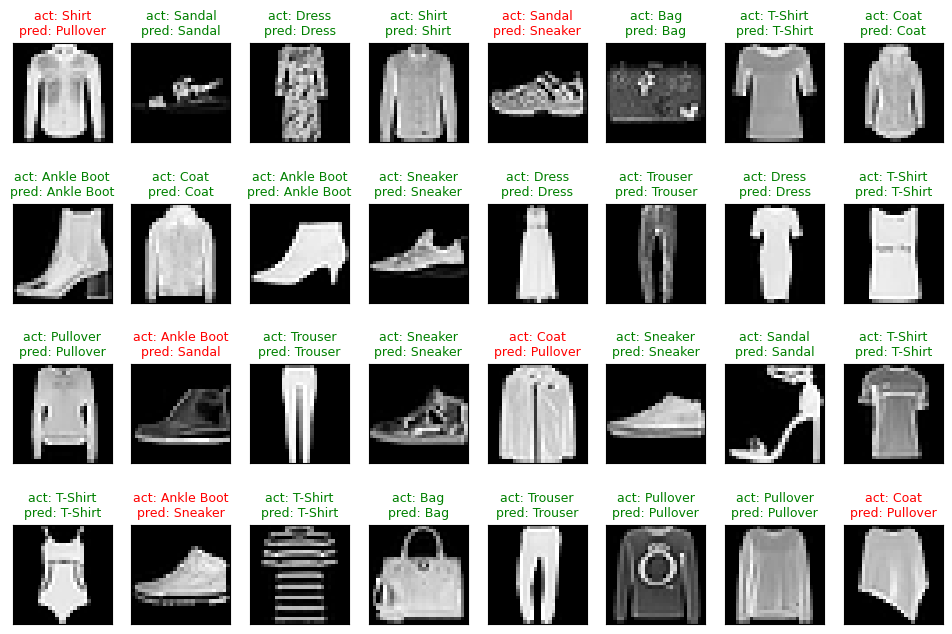

In [53]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(12, 8))
index = 0
for i in range(4):
    for j in range(8):
        act_label = labels_map[y_samples[index].item()]
        pred_label = labels_map[y_samples_pred[index].item()]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 4: Create a Model MLP with L2 Regularization**
---

- First, we're gonna recreate the `train` function to accomodate regularization

In [54]:
def train_regularize(model, max_epoch, train_loader, optimizer):
    """Train the model"""
    # Initialize
    train_acc_list = []
    valid_acc_list = []
    losses = []

    # Start iteration
    start_time = time.time()
    for epoch in range(max_epoch):
        # Training -- iterate over batch
        model.train()
        for batch_idx, (imgs, targets) in enumerate(train_loader):
            # Forward pass
            logits = model(imgs)
            loss = F.cross_entropy(logits, targets)

            # IN HERE ---
            # We find the regularizing term, i.e. ||w||2
            L2 = 0.
            for lyr_name, lyr_param in model.named_parameters():
                if 'weight' in lyr_name:
                    L2 += (lyr_param**2).sum()

            # Add L2 to the loss
            loss = loss + 0.5 * (CONFIG.lamda/len(targets)) * L2

            # Backpropagation
            model.zero_grad(set_to_none=True)
            loss.backward()

            # Update the model parameter
            optimizer.step()

            # Log the minibatch (inner iteration)
            losses.append(loss.item())
            if not batch_idx % int(len(train_loader)/2.):
                print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                      f'| Batch: {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        # Inference
        model.eval()
        with torch.no_grad():
            train_acc, _ = get_inference(model, 'train')
            valid_acc, _ = get_inference(model, 'valid')

            print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                  f'| Train: {train_acc:.2f}% '
                  f'| Valid: {valid_acc:.2f}%')
            print('')

            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

    # Finalize
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    return losses, train_acc_list, valid_acc_list


- Next we create the model.
- We can regularize our `MLPDeeper`

In [55]:
# Initialize models
model_mlp_l2 = MLPDeeper(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp_l2.parameters()))

Total parameters : 42310


- Then, we start training

In [56]:
# Define optimizer
optimizer_4 = torch.optim.SGD(params = model_mlp_l2.parameters(),
                              lr = CONFIG.lr)

In [57]:
losses_mlp_l2, train_acc_mlp_l2, valid_acc_mlp_l2 = train_regularize(model=model_mlp_l2,
                                                                     max_epoch=CONFIG.max_epochs,
                                                                     train_loader=train_loader,
                                                                     optimizer=optimizer_4)

Epoch: 001/050 | Batch: 0000/0921 | Loss: 2.3600
Epoch: 001/050 | Batch: 0460/0921 | Loss: 0.9017
Epoch: 001/050 | Batch: 0920/0921 | Loss: 0.6677
Epoch: 001/050 | Train: 82.39% | Valid: 82.00%

Epoch: 002/050 | Batch: 0000/0921 | Loss: 0.7677
Epoch: 002/050 | Batch: 0460/0921 | Loss: 0.6113
Epoch: 002/050 | Batch: 0920/0921 | Loss: 0.4924
Epoch: 002/050 | Train: 84.03% | Valid: 84.00%

Epoch: 003/050 | Batch: 0000/0921 | Loss: 0.2912
Epoch: 003/050 | Batch: 0460/0921 | Loss: 0.4999
Epoch: 003/050 | Batch: 0920/0921 | Loss: 0.5516
Epoch: 003/050 | Train: 82.77% | Valid: 83.00%

Epoch: 004/050 | Batch: 0000/0921 | Loss: 0.4928


Epoch: 004/050 | Batch: 0460/0921 | Loss: 0.4843
Epoch: 004/050 | Batch: 0920/0921 | Loss: 0.4344
Epoch: 004/050 | Train: 86.67% | Valid: 86.70%

Epoch: 005/050 | Batch: 0000/0921 | Loss: 0.5240
Epoch: 005/050 | Batch: 0460/0921 | Loss: 0.5593
Epoch: 005/050 | Batch: 0920/0921 | Loss: 0.5031
Epoch: 005/050 | Train: 85.82% | Valid: 85.00%

Epoch: 006/050 | Batch: 0000/0921 | Loss: 0.3457
Epoch: 006/050 | Batch: 0460/0921 | Loss: 0.4246
Epoch: 006/050 | Batch: 0920/0921 | Loss: 0.4320
Epoch: 006/050 | Train: 86.96% | Valid: 87.10%

Epoch: 007/050 | Batch: 0000/0921 | Loss: 0.5004
Epoch: 007/050 | Batch: 0460/0921 | Loss: 0.3745
Epoch: 007/050 | Batch: 0920/0921 | Loss: 0.2994
Epoch: 007/050 | Train: 86.97% | Valid: 86.40%

Epoch: 008/050 | Batch: 0000/0921 | Loss: 0.3308
Epoch: 008/050 | Batch: 0460/0921 | Loss: 0.4674
Epoch: 008/050 | Batch: 0920/0921 | Loss: 0.3881
Epoch: 008/050 | Train: 87.80% | Valid: 87.50%

Epoch: 009/050 | Batch: 0000/0921 | Loss: 0.4395
Epoch: 009/050 | Batch: 0

- Plot the loss & accuracy

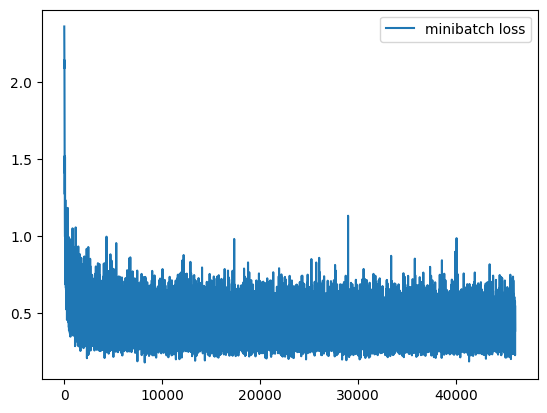

In [58]:
plt.plot(np.arange(len(losses_mlp_l2)), losses_mlp_l2, c='tab:blue', label='minibatch loss')
plt.legend()
plt.show()

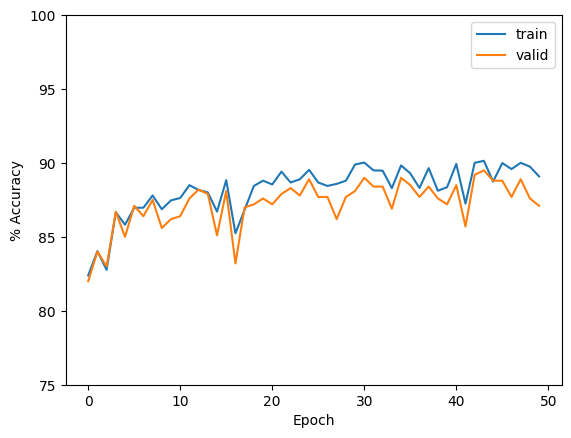

In [59]:
plt.plot(np.arange(len(train_acc_mlp_l2)), train_acc_mlp_l2, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp_l2)), valid_acc_mlp_l2, c='tab:orange', label='valid')
plt.ylabel('% Accuracy'); plt.xlabel('Epoch')
plt.ylim(75, 100)
plt.legend()
plt.show()

- Validate on train & valid data

In [60]:
# Calculate
train_acc_mlp_l2, train_loss_mlp_l2 = get_inference(model_mlp_l2, 'train')
valid_acc_mlp_l2, valid_loss_mlp_l2 = get_inference(model_mlp_l2, 'valid')

In [61]:
# Summarize in dataframe
summary_df.loc['MLP L2'] = np.array([train_acc_mlp_l2,
                                         valid_acc_mlp_l2,
                                         train_loss_mlp_l2,
                                         valid_loss_mlp_l2])
summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,94.689873,88.800003,0.147846,0.327279
MLP Deeper,93.661781,88.199997,0.163049,0.387818
MLP dropout,87.813858,87.000000,0.331931,0.377901
MLP L2,89.082855,87.099998,0.294435,0.338951


- Finally, we predict the model samples

In [62]:
# Get prediction
model_mlp.eval()
with torch.no_grad():
    logits_sample = model_mlp_l2(X_samples)
    probs_sample = F.softmax(logits_sample, dim=1)
    y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([6, 5, 3, 6, 7, 8, 0, 4, 9, 4, 9, 7, 3, 1, 3, 6, 2, 7, 1, 7, 2, 7, 5, 0,
        6, 7, 0, 8, 1, 2, 6, 2, 1, 2, 1, 6, 7, 7, 4, 9, 8, 7, 7, 1, 0, 0, 5, 3,
        6, 2, 5, 1, 5, 0, 6, 4, 3, 8, 8, 8, 1, 9, 2, 5])

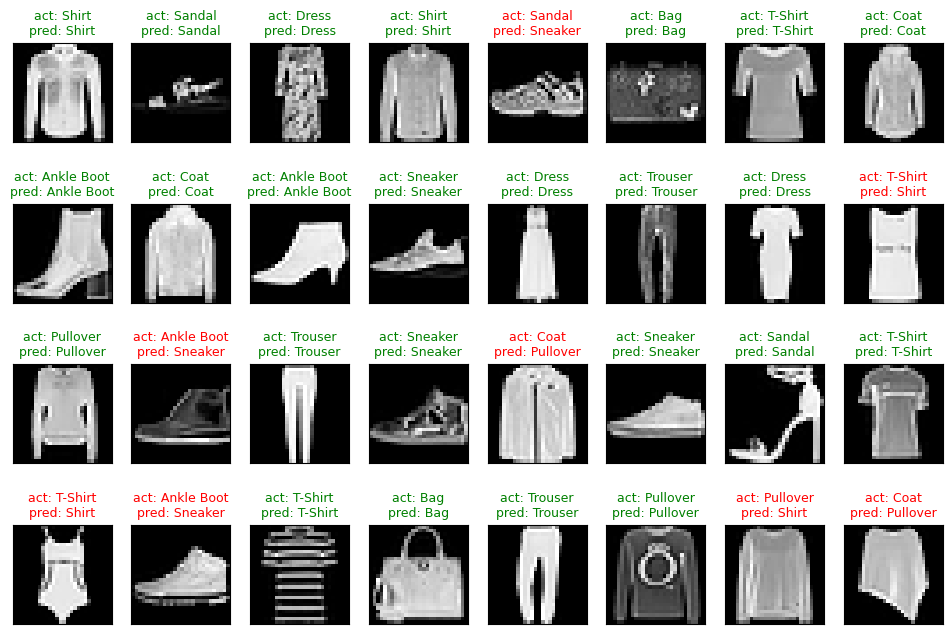

In [63]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(12, 8))
index = 0
for i in range(4):
    for j in range(8):
        act_label = labels_map[y_samples[index].item()]
        pred_label = labels_map[y_samples_pred[index].item()]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## **Task 5: Create a Model MLP with Adam Optimization Method**
---

- In this task, we try other optimization method, i.e. Adam
- Our base model would be the `MLPDeeper`

In [64]:
# Initialize models
model_mlp_adam = MLPDeeper(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp_adam.parameters()))

Total parameters : 42310


- Then, we start training

In [65]:
# Define optimizer
optimizer_5 = torch.optim.Adam(params = model_mlp_adam.parameters(),
                               lr = 1e-4,
                               betas = (0.9, 0.999))

In [66]:
losses_mlp_adam, train_acc_mlp_adam, valid_acc_mlp_adam = train(model=model_mlp_adam,
                                                                max_epoch=CONFIG.max_epochs,
                                                                train_loader=train_loader,
                                                                optimizer=optimizer_5)

Epoch: 001/050 | Batch: 0000/0921 | Loss: 2.3315
Epoch: 001/050 | Batch: 0460/0921 | Loss: 0.9895
Epoch: 001/050 | Batch: 0920/0921 | Loss: 0.8730
Epoch: 001/050 | Train: 76.53% | Valid: 76.80%

Epoch: 002/050 | Batch: 0000/0921 | Loss: 0.9216
Epoch: 002/050 | Batch: 0460/0921 | Loss: 0.6937
Epoch: 002/050 | Batch: 0920/0921 | Loss: 0.5549
Epoch: 002/050 | Train: 81.80% | Valid: 81.00%

Epoch: 003/050 | Batch: 0000/0921 | Loss: 0.3619
Epoch: 003/050 | Batch: 0460/0921 | Loss: 0.4680


Epoch: 003/050 | Batch: 0920/0921 | Loss: 0.4828
Epoch: 003/050 | Train: 83.14% | Valid: 82.10%

Epoch: 004/050 | Batch: 0000/0921 | Loss: 0.4545
Epoch: 004/050 | Batch: 0460/0921 | Loss: 0.5551
Epoch: 004/050 | Batch: 0920/0921 | Loss: 0.4241
Epoch: 004/050 | Train: 84.03% | Valid: 83.60%

Epoch: 005/050 | Batch: 0000/0921 | Loss: 0.5749
Epoch: 005/050 | Batch: 0460/0921 | Loss: 0.5311
Epoch: 005/050 | Batch: 0920/0921 | Loss: 0.4696
Epoch: 005/050 | Train: 84.51% | Valid: 84.30%

Epoch: 006/050 | Batch: 0000/0921 | Loss: 0.3468
Epoch: 006/050 | Batch: 0460/0921 | Loss: 0.4461
Epoch: 006/050 | Batch: 0920/0921 | Loss: 0.2873
Epoch: 006/050 | Train: 85.05% | Valid: 84.90%

Epoch: 007/050 | Batch: 0000/0921 | Loss: 0.4662
Epoch: 007/050 | Batch: 0460/0921 | Loss: 0.3347
Epoch: 007/050 | Batch: 0920/0921 | Loss: 0.2991
Epoch: 007/050 | Train: 85.35% | Valid: 85.30%

Epoch: 008/050 | Batch: 0000/0921 | Loss: 0.3244
Epoch: 008/050 | Batch: 0460/0921 | Loss: 0.3421
Epoch: 008/050 | Batch: 0

- Plot the loss & accuracy

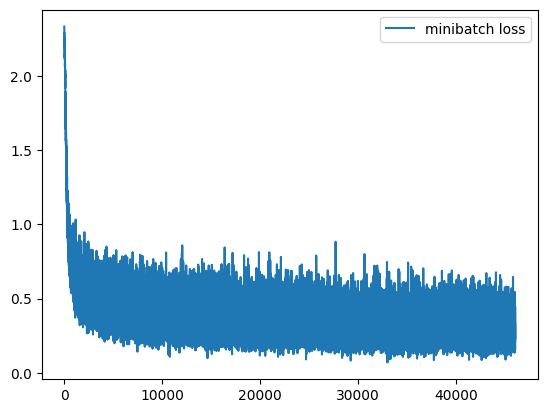

In [67]:
plt.plot(np.arange(len(losses_mlp_adam)), losses_mlp_adam, c='tab:blue', label='minibatch loss')
plt.legend()
plt.show()

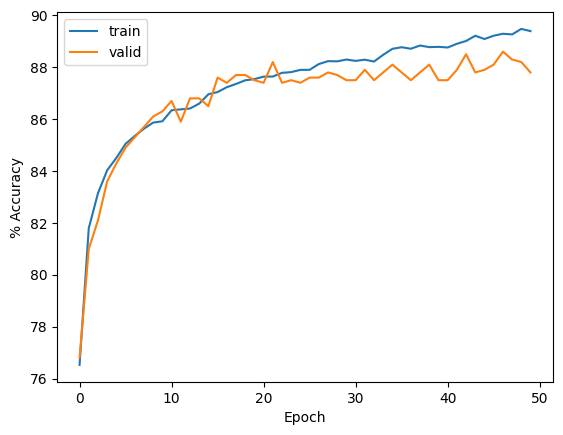

In [68]:
plt.plot(np.arange(len(train_acc_mlp_adam)), train_acc_mlp_adam, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp_adam)), valid_acc_mlp_adam, c='tab:orange', label='valid')
plt.ylabel('% Accuracy'); plt.xlabel('Epoch')
plt.legend()
plt.show()

- Validate on train & valid data

In [69]:
# Calculate
train_acc_mlp_adam, train_loss_mlp_adam = get_inference(model_mlp_adam, 'train')
valid_acc_mlp_adam, valid_loss_mlp_adam = get_inference(model_mlp_adam, 'valid')

In [70]:
# Summarize in dataframe
summary_df.loc['MLP adam'] = np.array([train_acc_mlp_adam,
                                       valid_acc_mlp_adam,
                                       train_loss_mlp_adam,
                                       valid_loss_mlp_adam])
summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,94.689873,88.800003,0.147846,0.327279
MLP Deeper,93.661781,88.199997,0.163049,0.387818
MLP dropout,87.813858,87.000000,0.331931,0.377901
MLP L2,89.082855,87.099998,0.294435,0.338951
MLP adam,89.396713,87.800003,0.301075,0.330376


- Finally, we predict the model samples

In [71]:
# Get prediction
model_mlp.eval()
with torch.no_grad():
    logits_sample = model_mlp_adam(X_samples)
    probs_sample = F.softmax(logits_sample, dim=1)
    y_samples_pred = probs_sample.max(1, keepdim=True)[1].view(-1)

y_samples_pred

tensor([4, 5, 3, 6, 7, 8, 0, 4, 9, 4, 9, 7, 3, 1, 3, 0, 2, 9, 1, 7, 2, 7, 5, 0,
        0, 7, 0, 8, 1, 2, 6, 4, 1, 2, 1, 4, 7, 7, 4, 9, 8, 7, 7, 1, 0, 0, 5, 3,
        6, 2, 5, 1, 5, 0, 6, 4, 3, 8, 8, 8, 1, 9, 2, 5])

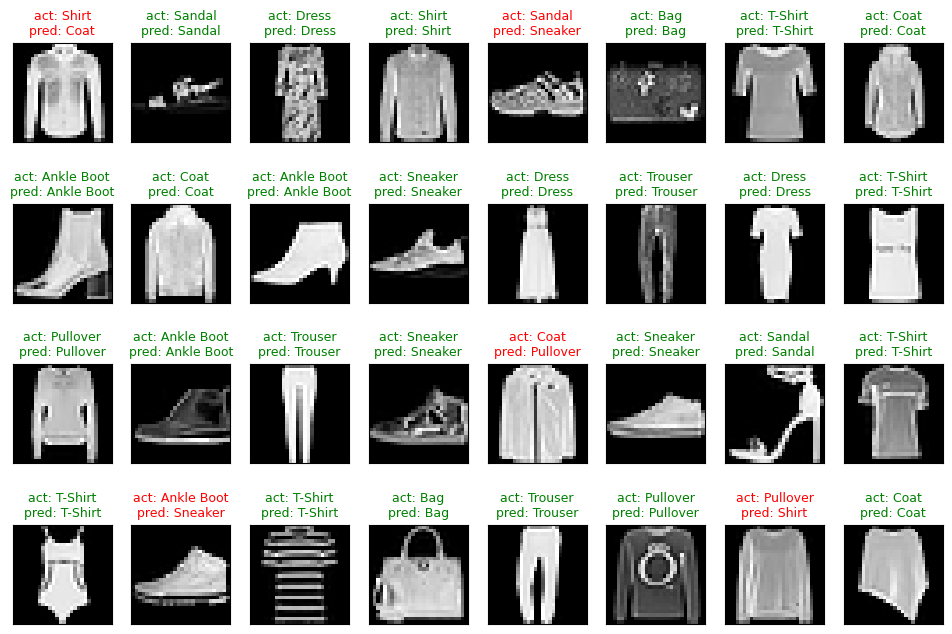

In [72]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(12, 8))
index = 0
for i in range(4):
    for j in range(8):
        act_label = labels_map[y_samples[index].item()]
        pred_label = labels_map[y_samples_pred[index].item()]
        if act_label==pred_label:
            color = 'g'
        else:
            color = 'r'
        axes[i,j].set_title(f'act: {act_label}\npred: {pred_label}', color=color, size=9)
        axes[i,j].imshow(X_samples[index].squeeze(), cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()